In [1]:
# Import the Necessary labraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Read the data
sales_data = pd.read_csv("Data Source (sales_transactions).csv")
df = sales_data.copy(deep=True)
df.head()

,TransactionID,CustomerID,TransactionDate,ProductID,ProductCategory,Quantity,PricePerUnit,TotalAmount,TrustPointsUsed,PaymentMethod,DiscountApplied
0,1,1002.0,08/08/24 22:00,2008,Grocery,1,10.0,10.0,20,Trust Points,5.0
1,2,NaN,07/08/24 1:00,2004,Home Decor,1,10.0,10.0,0,Credit Card,20.0
2,3,1004.0,02/08/24 19:00,2002,Grocery,3,30.0,90.0,0,Credit Card,25.0
3,2,1003.0,07/08/24 17:00,2001,Toys,2,30.0,60.0,50,NaN,20.0
4,5,1001.0,09/08/24 9:00,2008,Grocery,1,NaN,NaN,20,Trust Points,5.0


In [3]:
# data contain 50rows & 11 columns
df.shape

(50, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    50 non-null     int64  
 1   CustomerID       45 non-null     float64
 2   TransactionDate  49 non-null     object 
 3   ProductID        50 non-null     int64  
 4   ProductCategory  50 non-null     object 
 5   Quantity         50 non-null     int64  
 6   PricePerUnit     36 non-null     float64
 7   TotalAmount      36 non-null     float64
 8   TrustPointsUsed  50 non-null     int64  
 9   PaymentMethod    40 non-null     object 
 10  DiscountApplied  45 non-null     float64
dtypes: float64(4), int64(4), object(3)
memory usage: 4.4+ KB


## Preprocessing Steps

In [5]:
# Drop the nan values
df.dropna(subset=['PricePerUnit'],inplace=True)

In [6]:
df.isnull().sum()

TransactionID      0
CustomerID         5
TransactionDate    0
ProductID          0
ProductCategory    0
Quantity           0
PricePerUnit       0
TotalAmount        0
TrustPointsUsed    0
PaymentMethod      5
DiscountApplied    3
dtype: int64

In [7]:
# Change object dtype into datetime for Transactiondate column
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'],format='%d/%m/%y %H:%M',)

In [8]:
# Impute the missing values

price_imputer = SimpleImputer(strategy='most_frequent')
df['CustomerID'] = price_imputer.fit_transform(df[['CustomerID']])
df['PaymentMethod'] = price_imputer.fit_transform(df[['PaymentMethod']])

In [9]:
discount_imputer = SimpleImputer(strategy='mean')
df['DiscountApplied'] = discount_imputer.fit_transform(df[['DiscountApplied']])

In [10]:
# Recalculate the Total amount by multipy Quantity & Price per unit

In [11]:
# Validation was conducted by recalculating the TotalAmount and comparing it with the original values.

df['RecalculatedTotal'] = df['Quantity'] * df['PricePerUnit']
df['IsValidTotal'] = df['TotalAmount'] == df['RecalculatedTotal']

In [12]:
df.isnull().sum()

TransactionID        0
CustomerID           0
TransactionDate      0
ProductID            0
ProductCategory      0
Quantity             0
PricePerUnit         0
TotalAmount          0
TrustPointsUsed      0
PaymentMethod        0
DiscountApplied      0
RecalculatedTotal    0
IsValidTotal         0
dtype: int64

Preprocessing Summary

Steps Taken:

Handling Missing Values: Rows with critical missing values (like PricePerUnit and TotalAmount) were removed. Less critical columns like CustomerID and PaymentMethod still have some missing values.

Date Conversion: The TransactionDate was successfully converted to datetime format. Rows with invalid dates were dropped.

Duplicate Removal: Duplicate transactions based on TransactionID were removed.

Recalculation & Validation: The TotalAmount was recalculated as Quantity * PricePerUnit. 

## Data Aggregation and Grouping

In [13]:
aggregation = {
    'Quantity': ['sum', 'mean', 'min', 'max'],
    'TotalAmount': ['sum', 'mean', 'min', 'max'],
    'DiscountApplied': ['mean', 'sum'],
    'TrustPointsUsed': ['mean', 'sum']
}

In [14]:
# Grouping by ProductCategory
grouped_data = df.groupby('ProductCategory').agg(aggregation)

grouped_data

Quantity                   TotalAmount                     \
                     sum      mean min max         sum        mean    min   
ProductCategory                                                             
Electronics           12  1.090909  -1   3       360.0   32.727273 -500.0   
Fashion                5  1.666667   1   2      2050.0  683.333333   50.0   
Grocery                7  1.750000   1   3       320.0   80.000000   10.0   
Home Decor             6  0.857143  -1   3      2020.0  288.571429  -30.0   
Toys                  19  1.727273   1   3       840.0   76.363636   10.0   

                        DiscountApplied             TrustPointsUsed       
                    max            mean         sum            mean  sum  
ProductCategory                                                           
Electronics       500.0       22.066116  242.727273       46.363636  510  
Fashion          1000.0       25.000000   75.000000        3.333333   10  
Grocery           200.0       12.500000   50.000000        7.500000   30  
Home Decor       1500.0       28.246753  197.727273       35.714286  250  
Toys              200.0       22.975207  252.727273       10.000000  110

### Aggregation Results

Here is a summary of the aggregation based on ProductCategory:

#### Quantity:

Sum:
Total quantity sold per product category.

Mean: Average quantity sold per transaction.

Min/Max: The smallest and largest quantities sold in a single transaction.


#### TotalAmount:

 Sum:
Total revenue generated per product category.

Mean: Average revenue per transaction.

Min/Max: The smallest and largest transaction amounts.


#### DiscountApplied:

Mean: Average discount applied per transaction.

Sum: Total discounts given in each category.


#### TrustPointsUsed:

Mean: Average trust points used per transaction.

Sum: Total trust points redeemed in each product category.

# Data Validation

In [15]:
# Validation: Check for negative quantities or totals
invalid_data = df[(df['Quantity'] < 0) | (df['TotalAmount'] < 0)]
if not invalid_data.empty:
    print("Warning: Negative values detected in the data!")
else:
    print("Validation Passed: No negative quantities or totals found.")

In [16]:
# Check if recalculated total matches the original total
if df['IsValidTotal'].all():
    print("Validation Passed: All totals are correct!")
else:
    print("Validation Failed: Some totals are incorrect!")

Validation Passed: All totals are correct!


1. Correctness of Preprocessing: Validation was conducted by recalculating the TotalAmount and comparing it with the original values.

3. Data Integrity Checks: Include ensuring no duplicate transaction IDs, valid price points, and accurate date entries.

Addressing anomalies such as negative quantities or incorrect totals.

## Data Visualizations


In [17]:
df['ProductCategory'].value_counts()

Toys           11
Electronics    11
Home Decor      7
Grocery         4
Fashion         3
Name: ProductCategory, dtype: int64

In [18]:
# Aggregation example for visualizations
agg_data = df.groupby('ProductCategory').agg({
    'TotalAmount': 'sum',
    'DiscountApplied': 'sum'
}).reset_index()

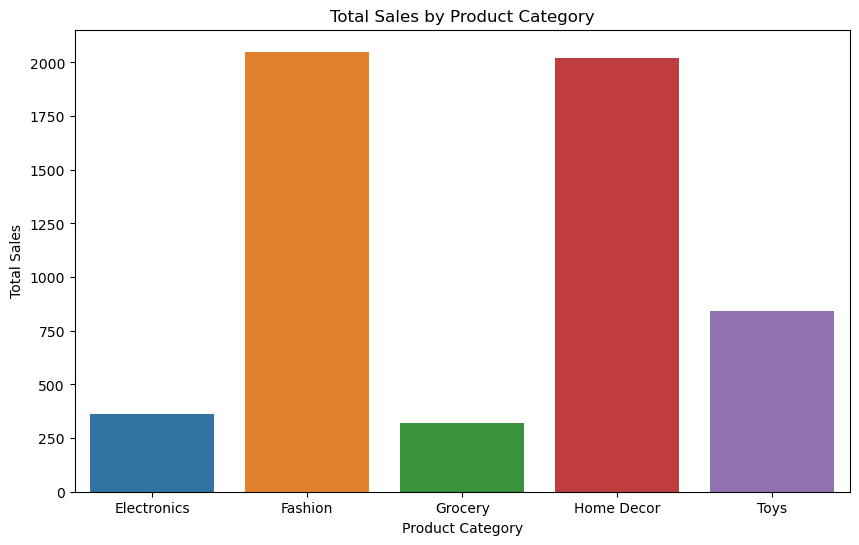

In [19]:
# Visualization 1: Bar Graph for Total Sales by Product Category
plt.figure(figsize=(10, 6))
sns.barplot(x='ProductCategory', y='TotalAmount', data=agg_data)
plt.title('Total Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.show()


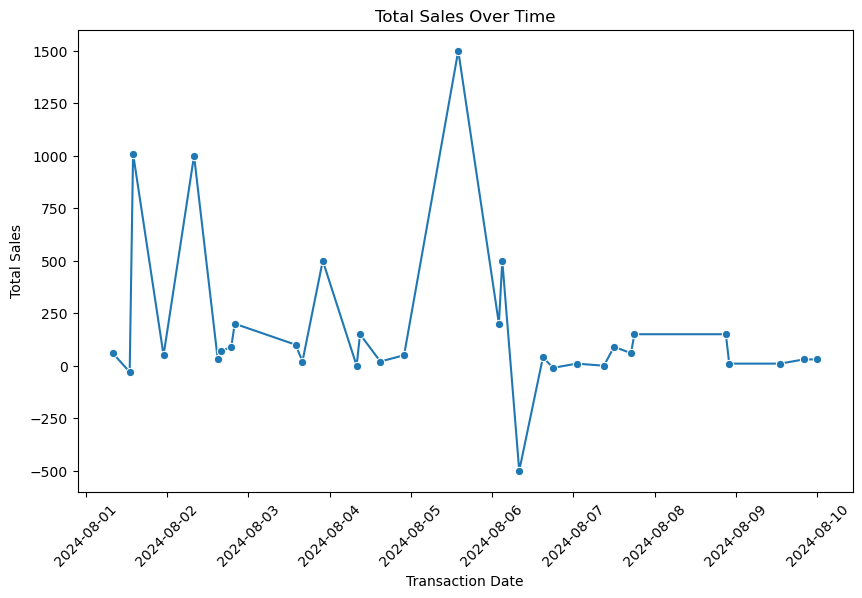

In [20]:
# Visualization 2: Line Chart for Total Sales over Time

sales_over_time = df.groupby('TransactionDate')['TotalAmount'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='TransactionDate', y='TotalAmount', data=sales_over_time, marker='o')
plt.title('Total Sales Over Time')
plt.xlabel('Transaction Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

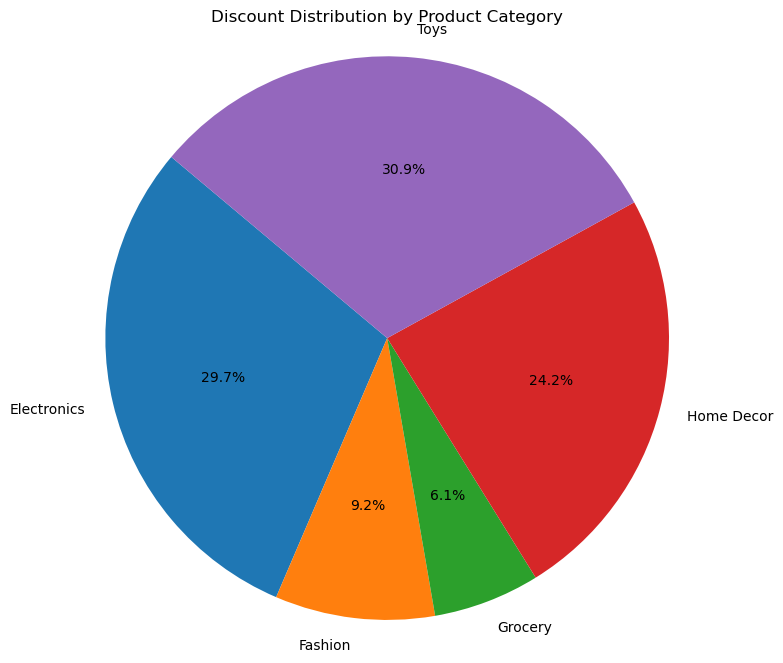

In [21]:
# Visualization 3: Pie Chart for Discount Distribution by Product Category

plt.figure(figsize=(8, 8))
plt.pie(agg_data['DiscountApplied'], labels=agg_data['ProductCategory'], autopct='%1.1f%%', startangle=140)
plt.title('Discount Distribution by Product Category')
plt.axis('equal')
plt.show()

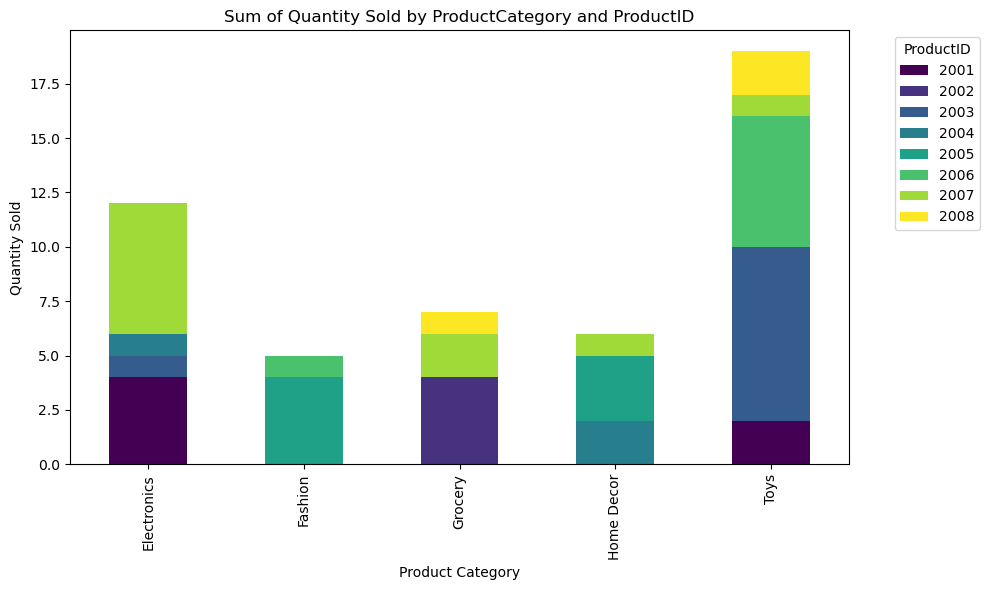

In [22]:
# Group by ProductCategory and ProductID to calculate the sum of Quantity sold

category_product_quantity = df.groupby(['ProductCategory', 'ProductID'])['Quantity'].sum().unstack(fill_value=0)

# Plotting the Stacked Bar Graph
category_product_quantity.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Sum of Quantity Sold by ProductCategory and ProductID')
plt.xlabel('Product Category')
plt.ylabel('Quantity Sold')
plt.legend(title='ProductID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

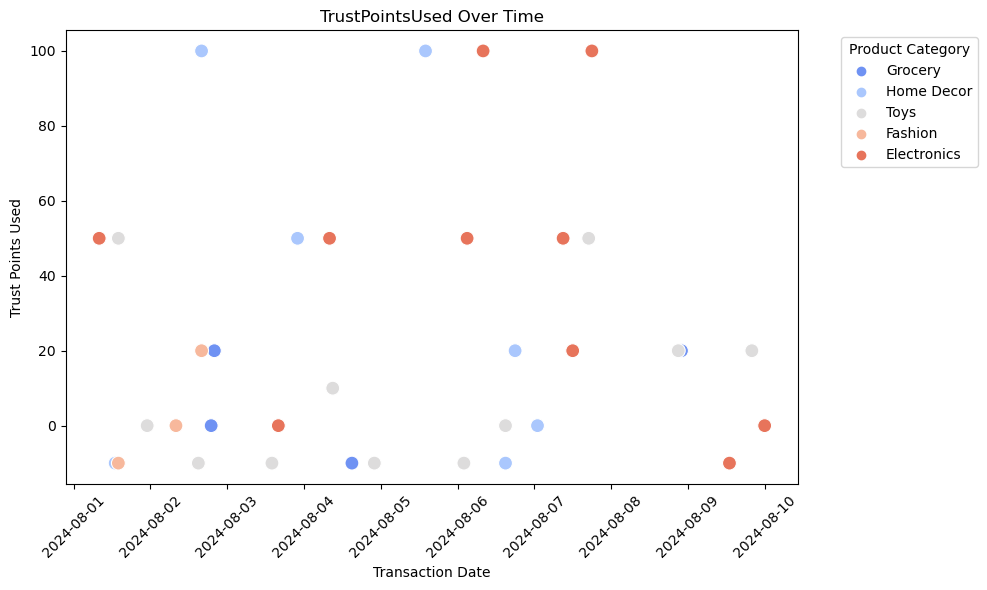

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TransactionDate', y='TrustPointsUsed', data=df, hue='ProductCategory', palette='coolwarm', s=100)
plt.title('TrustPointsUsed Over Time')
plt.xlabel('Transaction Date')
plt.ylabel('Trust Points Used')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the chart
plt.tight_layout()

## Linear Projection Check

In [24]:
correlation_matrix = df[['Quantity', 'TotalAmount', 'DiscountApplied', 'TrustPointsUsed']].corr()

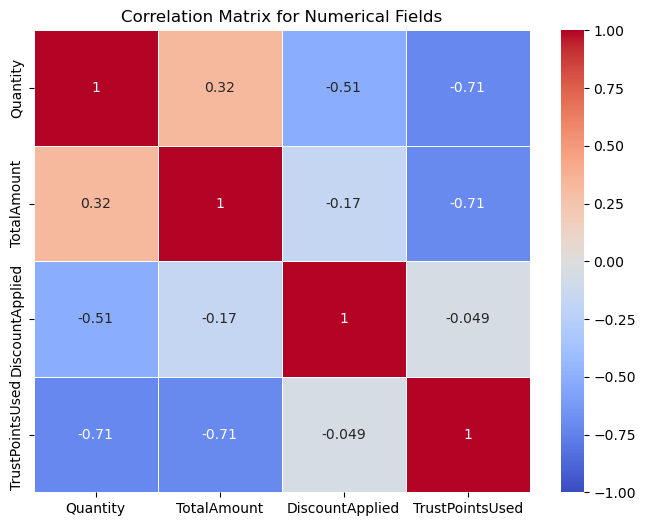

In [25]:
# Visualization: Heatmap for Correlation Matrix

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix.corr(), annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numerical Fields')
plt.show()

Correlation Coefficients: If the coefficient between Quantity and TotalAmount is close to 1, it indicates a strong positive linear relationship, implying the higher the quantity, the higher the total amount.

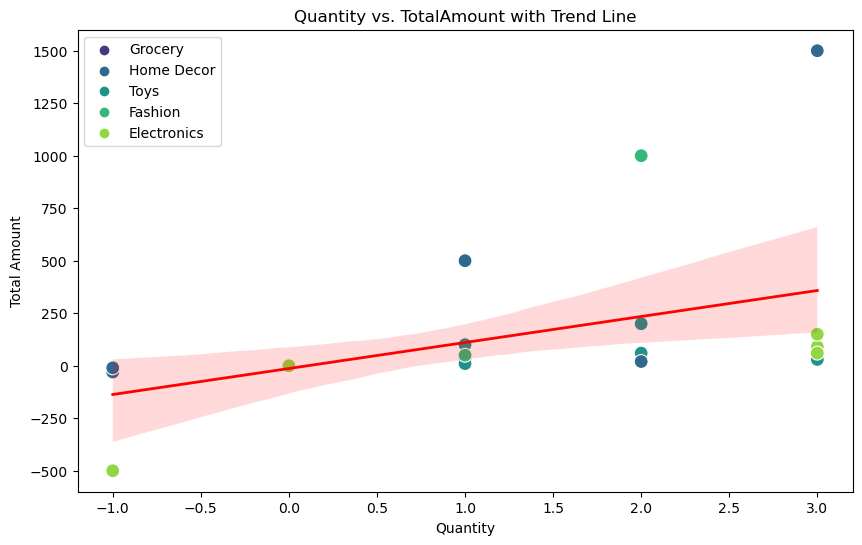

In [26]:
# Scatter Plot with Trend Line: Quantity vs. TotalAmount

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='TotalAmount', data=df, hue='ProductCategory', palette='viridis', s=100)
sns.regplot(x='Quantity', y='TotalAmount', data=df, scatter=False, color='red', line_kws={'linewidth': 2, 'label': 'Trend Line'})
plt.title('Quantity vs. TotalAmount with Trend Line')
plt.xlabel('Quantity')
plt.ylabel('Total Amount')
plt.legend()
plt.show()

Trend Lines: A straight line would indicate a linear relationship between the two variables.